In [6]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training import *
from helpers.visualizations import *
from helpers.preprocessing import *
from helpers.aequitas_methods import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import warnings
from sklearn.preprocessing import MinMaxScaler
from helpers.mitigation_methods import *
from aequitas import Audit
import math
warnings.filterwarnings(action='ignore')
#### open ml id : 44096

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df = pd.read_csv("dataset/german_credit.csv")
df['target'] = np.where(df['target']==2,0,1)
df = df.drop(columns = ['Unnamed: 0'], axis=1)

In [8]:
def categorize_age(age):
    if age<30:
        return '<=30'
    if age>=30:
        return '>30'
df['age'] = df['age'].apply(categorize_age).astype(object)
df['age'].value_counts()

protected_attributes = ["housing","gender","num_people_maintenance","age"]
target = 'target'
df["housing"] = np.where(df['housing']=="own","own","not own")

df_num = encode_and_scale(df, target)
df_num["num_people_maintenance"] = df_num["num_people_maintenance"].astype(int)

['acc_status', 'credit_history', 'purpose', 'savings_acc', 'employment_time', 'gender', 'other_debtors', 'property', 'age', 'installment_plans', 'housing', 'job', 'phone', 'foreigner']
Attribute: acc_status
{'dm_0_to_200': 0, 'dm_greater_eq_200': 1, 'dm_less_than_0': 2, 'no_acc': 3}
Attribute: credit_history
{'credit_paid_so_far': 0, 'critical_amount': 1, 'delay_in_past_credit_payment': 2, 'no_credit_all': 3, 'no_credit_this_bank': 4}
Attribute: purpose
{'business': 0, 'car_new': 1, 'car_old': 2, 'domestic_appliances': 3, 'education': 4, 'furniture_or_equipment': 5, 'other': 6, 'radio_or_tv': 7, 'repairs': 8, 'retraining': 9}
Attribute: savings_acc
{'dm_100_to_500': 0, 'dm_500_to_1000': 1, 'dm_greater_eq_1000': 2, 'dm_less_100': 3, 'unknown_or_no_savings': 4}
Attribute: employment_time
{'four_to_seven': 0, 'greater_eq_seven': 1, 'less_one': 2, 'one_to_four': 3, 'unemployed': 4}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: other_debtors
{'co-applicant': 0, 'guarantor': 1, 'none

In [9]:
"""
num_people_maintenance: Number of people being liable to provide maintenance for
housing: Type of housing, either owning or not (free & rent attributes are combined together)
"""

df_intersect = df.copy()

df_intersect["num_people_maintenance/gender"] = df_intersect["num_people_maintenance"].astype(str)+ "-" + df_intersect["gender"]
df_intersect["gender/housing"] = df_intersect["gender"] + "-" + df_intersect["housing"]
df_intersect["num_people_maintenance/housing"] = df_intersect["num_people_maintenance"].astype(str) + "-" + df_intersect["housing"]
df_intersect["gender/age"] = df_intersect["gender"] + "-" + df_intersect["age"]
df_intersect.drop(protected_attributes, axis=1, inplace=True)

protected_attributes_int = ["num_people_maintenance/gender","gender/housing","num_people_maintenance/housing", "gender/age"]

df_num_int = encode_and_scale(df_intersect, target)

['acc_status', 'credit_history', 'purpose', 'savings_acc', 'employment_time', 'other_debtors', 'property', 'installment_plans', 'job', 'phone', 'foreigner', 'num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing', 'gender/age']
Attribute: acc_status
{'dm_0_to_200': 0, 'dm_greater_eq_200': 1, 'dm_less_than_0': 2, 'no_acc': 3}
Attribute: credit_history
{'credit_paid_so_far': 0, 'critical_amount': 1, 'delay_in_past_credit_payment': 2, 'no_credit_all': 3, 'no_credit_this_bank': 4}
Attribute: purpose
{'business': 0, 'car_new': 1, 'car_old': 2, 'domestic_appliances': 3, 'education': 4, 'furniture_or_equipment': 5, 'other': 6, 'radio_or_tv': 7, 'repairs': 8, 'retraining': 9}
Attribute: savings_acc
{'dm_100_to_500': 0, 'dm_500_to_1000': 1, 'dm_greater_eq_1000': 2, 'dm_less_100': 3, 'unknown_or_no_savings': 4}
Attribute: employment_time
{'four_to_seven': 0, 'greater_eq_seven': 1, 'less_one': 2, 'one_to_four': 3, 'unemployed': 4}
Attribute: other_debtors
{'co-applican

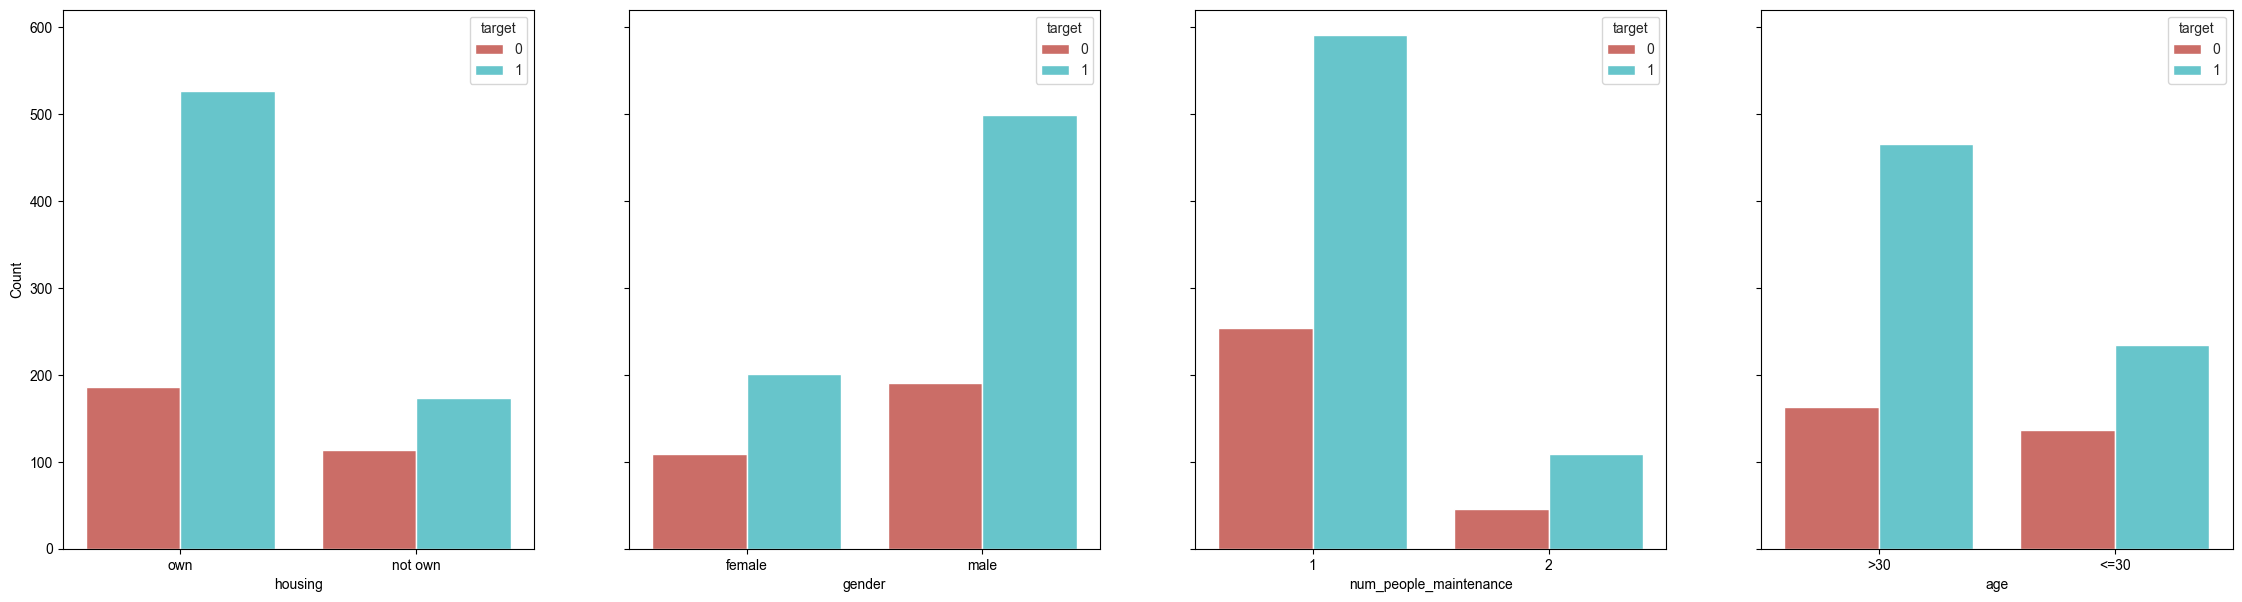

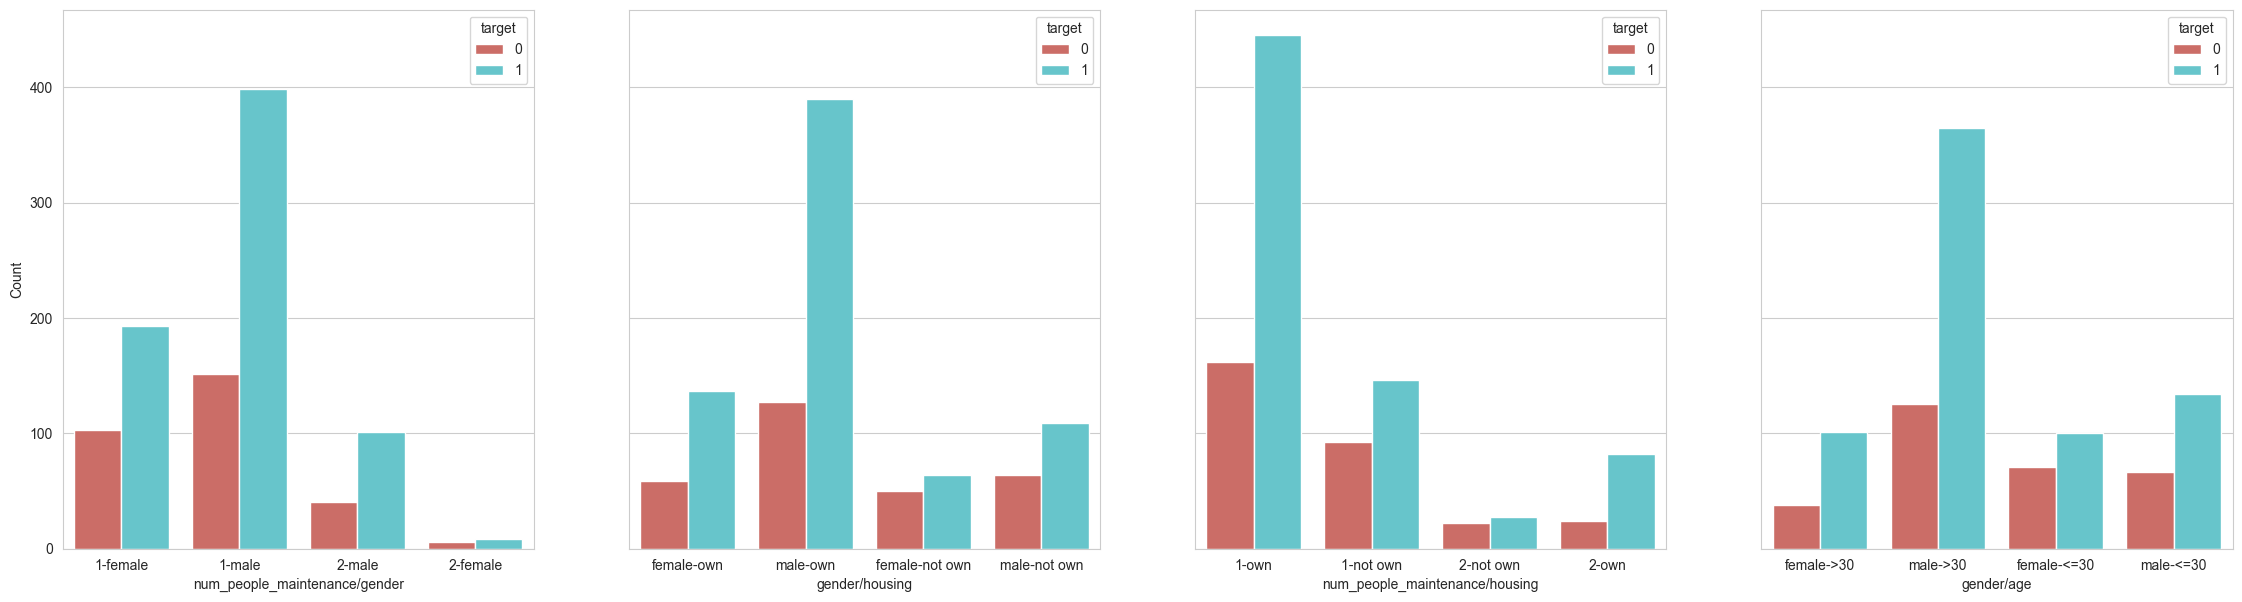

In [10]:
plot_attributes(df,protected_attributes,target=target, num_rows=4, num_cols=1)
plot_attributes(df_intersect, protected_attributes_int, target=target, num_rows=4, num_cols=2)

In [13]:
df_intersect

,acc_status,acc_duration,credit_history,purpose,credit_amount,savings_acc,employment_time,installment_rate,other_debtors,residence_time,...,installment_plans,num_credits_at_bank,job,phone,foreigner,target,num_people_maintenance/gender,gender/housing,num_people_maintenance/housing,gender/age
0,dm_0_to_200,7,credit_paid_so_far,radio_or_tv,2329,dm_less_100,less_one,1,guarantor,1,...,none,1,skilled_employee_or_official,no,yes,1,1-female,female-own,1-own,female->30
1,no_acc,24,credit_paid_so_far,radio_or_tv,5943,unknown_or_no_savings,less_one,1,none,1,...,none,2,skilled_employee_or_official,yes,yes,0,1-female,female-own,1-own,female->30
2,dm_0_to_200,24,credit_paid_so_far,car_new,3512,dm_100_to_500,four_to_seven,2,none,3,...,bank,2,skilled_employee_or_official,yes,yes,1,1-male,male-own,1-own,male->30
3,no_acc,21,delay_in_past_credit_payment,furniture_or_equipment,1591,dm_100_to_500,four_to_seven,4,none,3,...,none,2,self_or_highly_qualified_employee,no,yes,1,1-male,male-own,1-own,male->30
4,dm_less_than_0,12,credit_paid_so_far,car_new,1274,dm_less_100,less_one,3,none,1,...,none,1,unskilled_resident,no,yes,0,1-female,female-own,1-own,female->30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no_acc,18,critical_amount,radio_or_tv,6070,dm_less_100,greater_eq_seven,3,none,4,...,none,2,skilled_employee_or_official,yes,yes,1,1-male,male-own,1-own,male->30
996,no_acc,33,critical_amount,car_old,7253,dm_less_100,four_to_seven,3,none,2,...,none,2,self_or_highly_qualified_employee,yes,yes,1,1-male,male-own,1-own,male->30
997,dm_less_than_0,18,critical_amount,radio_or_tv,1880,dm_less_100,four_to_seven,4,none,1,...,none,2,self_or_highly_qualified_employee,yes,yes,1,1-male,male-own,1-own,male->30
998,no_acc,48,credit_paid_so_far,business,4844,dm_less_100,unemployed,3,none,2,...,bank,1,self_or_highly_qualified_employee,yes,yes,0,1-male,male-not own,1-not own,male->30


In [10]:
def split_and_train(data, attributes):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
    models = {"Catboost",
                  "LogisticRegression",
                  "RandomForest",
                  "DecisionTree"
                  }
    y_predicted_dict = {}
    metrics_dict = {}
    for m in models:
            model = choose_model(m, x_train, y_train)
            y_predicted =  evaluate_model(model, x_train, x_test, y_train, y_test)
            attribute_metrics  = calc_metrics(x_test=x_test,y_test=y_test,y_predicted=y_predicted,attributes=attributes, target=target)
            metrics_dict[m] = attribute_metrics
            y_predicted_dict[m] = y_predicted
            print(f"Classification report for model: {model} : \n {classification_report(y_test, y_predicted)}")
            # plot_roc_curve(y_true=y_test, y_pred=y_predicted, model_name=m)
    return x_test, y_test, y_predicted_dict, metrics_dict

def plot_audit(dataset, attributes):
    audit = Audit(dataset[['score','label_value']+attributes])
    summary = audit.summary_plot(["tpr","fpr","fnr","tnr","pprev"])
    summary.show()

---------- Model name:  Catboost ----------

Accuracy score training:
0.8650
Accuracy score test:
0.7500
----------------------------------------

Privileged groups:  [{'housing': 1}]
Unprivileged groups:  [{'housing': 0}]
Disparate Impact Ratio for housing: 0.894
Normalized Disparate Impact Ratio for housing: 0.894
Statistical Parity Difference for housing: -0.087


Privileged groups:  [{'gender': 1}]
Unprivileged groups:  [{'gender': 0}]
Disparate Impact Ratio for gender: 0.804
Normalized Disparate Impact Ratio for gender: 0.804
Statistical Parity Difference for gender: -0.167


Privileged groups:  [{'num_people_maintenance': 0}]
Unprivileged groups:  [{'num_people_maintenance': 1}]
Disparate Impact Ratio for num_people_maintenance: 1.076
Normalized Disparate Impact Ratio for num_people_maintenance: 0.924
Statistical Parity Difference for num_people_maintenance: 0.060


Privileged groups:  [{'age': 1}]
Unprivileged groups:  [{'age': 0}]
Disparate Impact Ratio for age: 0.837
Normalize

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,housing,0,0.66,0.97,0.26,0.14,0.37,0.74,0.03,0.86,0.63,0.25,0.87,0.57
1,housing,1,0.77,0.95,0.10,0.67,0.20,0.90,0.05,0.33,0.80,0.75,0.94,0.79
2,gender,0,0.75,0.95,0.28,0.29,0.25,0.72,0.05,0.71,0.75,0.29,0.88,0.70
3,gender,1,0.74,0.95,0.11,0.56,0.24,0.89,0.05,0.44,0.76,0.71,0.94,0.74
4,num_people_maintenance,0,0.73,0.94,0.15,0.50,0.25,0.85,0.06,0.50,0.75,0.86,0.92,0.73
5,num_people_maintenance,1,0.81,1.00,0.29,0.00,0.20,0.71,0.00,1.00,0.80,0.14,0.93,0.74
6,age,0,0.69,0.93,0.11,0.60,0.29,0.89,0.07,0.40,0.71,0.30,0.92,0.70
7,age,1,0.76,0.96,0.19,0.36,0.23,0.81,0.04,0.64,0.77,0.70,0.92,0.74


Majority class for:  housing  is: 1
Majority class for:  gender  is: 1
Majority class for:  num_people_maintenance  is: 0
Majority class for:  age  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,housing,0,1.82,0.64,0.21,0.82,2.57,0.33,0.92,0.79,...,False,False,False,False,False,False,False,False,False,False
1,housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,gender,0,1.00,0.99,0.51,0.81,1.61,0.40,0.94,1.00,...,False,False,False,False,False,False,False,False,False,False
3,gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
4,num_people_maintenance,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
5,num_people_maintenance,1,0.80,0.00,0.00,0.84,2.00,0.16,1.01,1.07,...,False,False,False,False,False,False,False,False,False,False
6,age,0,1.26,1.80,1.65,1.10,0.63,0.44,1.00,0.92,...,False,False,False,False,False,False,False,False,False,False
7,age,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


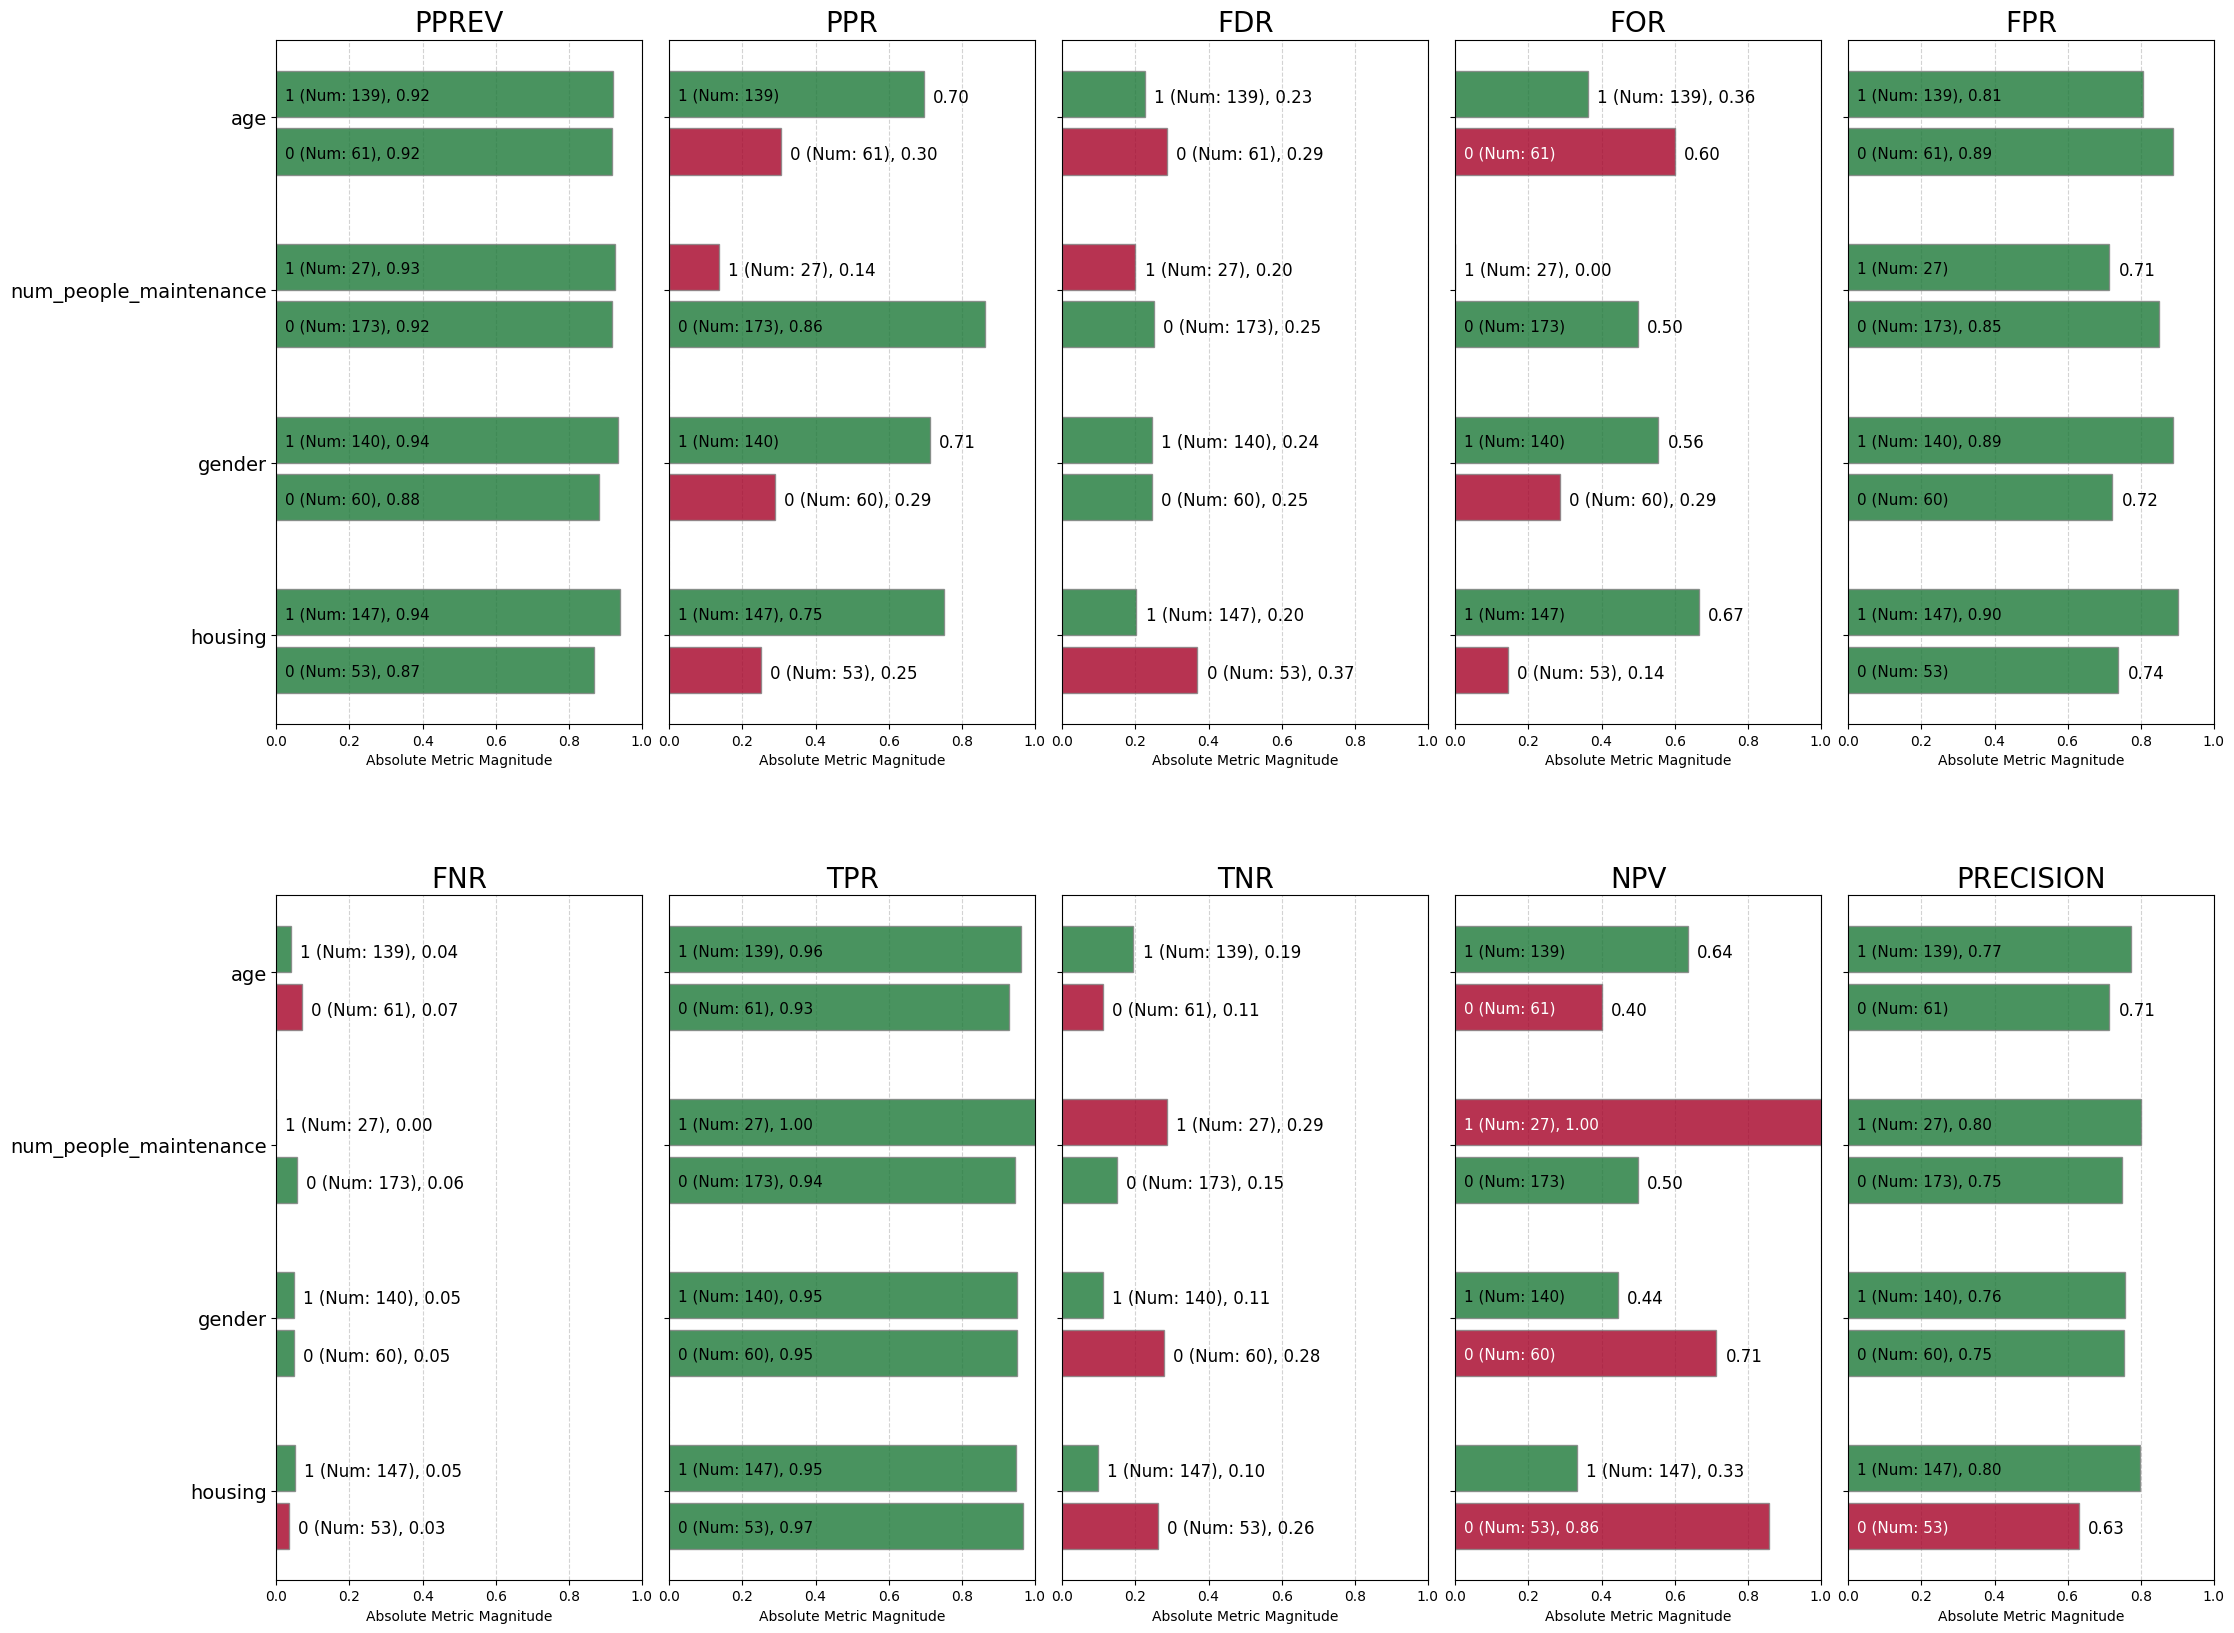

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,age,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False
1,0,binary 0/1,gender,False,True,True,True,False,True,True,False,False,True,True,False,True,False,False
2,0,binary 0/1,housing,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False
3,0,binary 0/1,num_people_maintenance,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False


<Figure size 640x480 with 0 Axes>

In [12]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df_num,protected_attributes)
df_test = calc_fairness_report(x_test, y_test, y_predicted_dict['RandomForest'], target, protected_attributes, display_disp=True)

In [18]:
"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_num_int,protected_attributes_int)
df_test_int = calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['RandomForest'], target, protected_attributes_int, display_disp=True)

---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.7312
Accuracy score test:
0.7450
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]


AttributeError: 'ClassificationMetric' object has no attribute 'true_negative_rate_difference'

In [50]:
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [30]:
protected_attributes_int

['num_people_maintenance/gender',
 'gender/housing',
 'num_people_maintenance/housing',
 'gender/age',
 'num_people_maintenance/age',
 'housing/age']

---------- Model name:  Catboost ----------

Accuracy score training:
0.9237
Accuracy score test:
0.8850
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Disparate Impact Ratio for num_people_maintenance/gender: 0.931
Normalized Disparate Impact Ratio for num_people_maintenance/gender: 0.931
Statistical Parity Difference for num_people_maintenance/gender: -0.055


Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 0.863
Normalized Disparate Impact Ratio for gender/housing: 0.863
Statistical Parity Difference for gender/housing: -0.113


Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_maint

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.91,0.98,0.71,0.09,0.09,0.29,0.02,0.91,0.91,0.29,0.81,0.75
1,num_people_maintenance/gender,1,0.87,0.99,0.60,0.05,0.15,0.40,0.01,0.95,0.85,0.58,0.81,0.70
2,num_people_maintenance/gender,2,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.01,0.67,0.67
3,num_people_maintenance/gender,3,0.83,0.94,0.57,0.20,0.16,0.43,0.06,0.80,0.84,0.12,0.79,0.71
4,gender/housing,0,0.95,1.00,0.86,0.00,0.07,0.14,0.00,1.00,0.93,0.09,0.70,0.65
5,gender/housing,1,0.90,0.97,0.62,0.17,0.09,0.38,0.03,0.83,0.91,0.21,0.85,0.80
6,gender/housing,2,0.91,0.90,0.92,0.15,0.05,0.08,0.10,0.85,0.95,0.12,0.61,0.64
7,gender/housing,3,0.85,1.00,0.47,0.00,0.17,0.53,0.00,1.00,0.83,0.58,0.87,0.72
8,num_people_maintenance/housing,0,0.94,0.97,0.88,0.06,0.06,0.12,0.03,0.94,0.94,0.19,0.66,0.64
9,num_people_maintenance/housing,1,0.87,0.99,0.50,0.06,0.15,0.50,0.01,0.94,0.85,0.68,0.87,0.75


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
Majority class for:  gender/age  is: 3
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,0.58,1.88,2.00,0.71,0.95,0.49,1.00,1.07,...,False,False,False,False,False,False,False,False,False,False
1,num_people_maintenance/gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,num_people_maintenance/gender,2,0.00,0.00,0.00,0.00,1.05,0.02,0.82,1.18,...,False,False,False,False,False,False,False,False,False,False
3,num_people_maintenance/gender,3,1.06,4.76,4.40,1.07,0.84,0.20,0.98,0.99,...,False,False,False,False,False,False,False,False,False,False
4,gender/housing,0,0.42,NaN,NaN,0.27,1.00,0.15,0.81,1.12,...,False,False,False,False,False,False,False,False,False,False
5,gender/housing,1,0.51,10.00,10.00,0.70,0.83,0.37,0.98,1.10,...,False,False,False,False,False,False,False,False,False,False
6,gender/housing,2,0.29,10.00,10.00,0.16,0.85,0.22,0.70,1.15,...,False,False,False,False,False,False,False,False,False,False
7,gender/housing,3,1.00,NaN,NaN,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
8,num_people_maintenance/housing,0,0.44,3.13,1.06,0.24,1.00,0.28,0.76,1.10,...,False,False,False,False,False,False,False,False,False,False
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


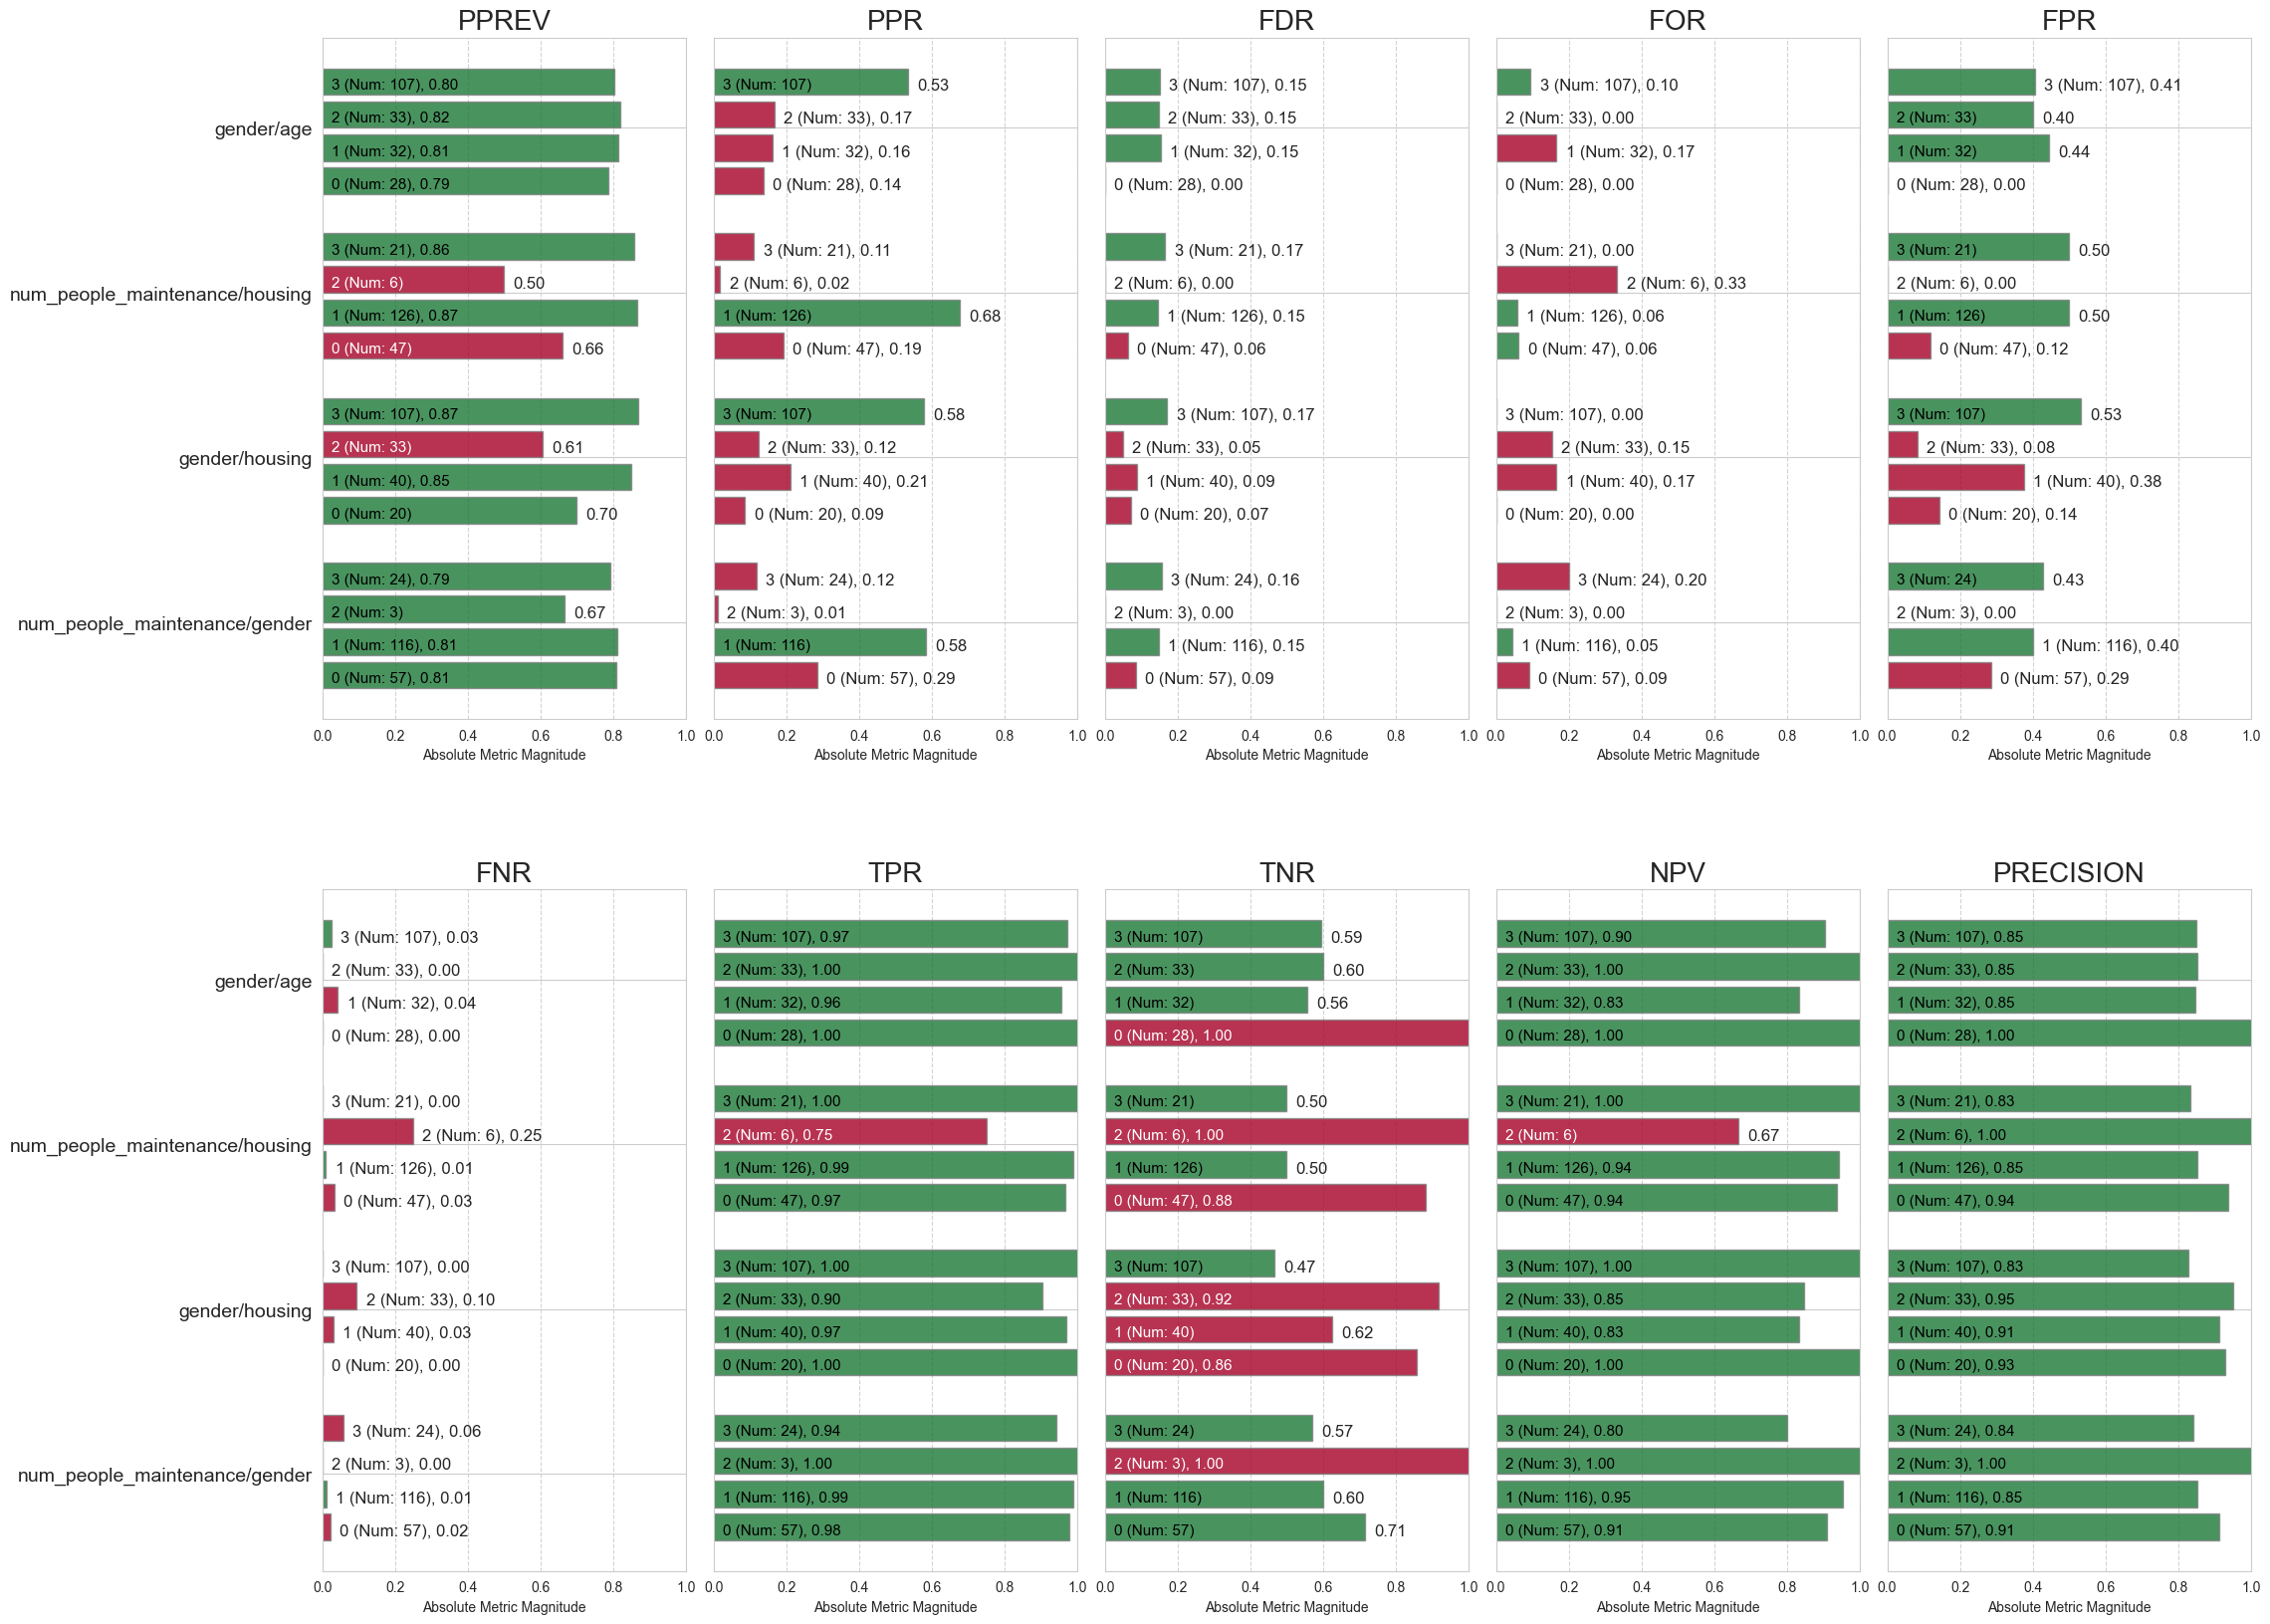

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,False,False,False,False,True,False,True,True,False,False,False,False,False
1,0,binary 0/1,gender/housing,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/gender,False,True,False,False,False,False,True,False,True,True,False,False,False,False,False
3,0,binary 0/1,num_people_maintenance/housing,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [52]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_m1 = pre_process_massaging(data_to_transform, "num_people_maintenance/gender",target)
data_transformed_m1["num_people_maintenance/gender"] = data_transformed_m1["num_people_maintenance/gender"].astype(int)
data_transformed_m2 = pre_process_massaging(data_transformed_m1, "gender/housing",target)
data_transformed_m2["gender/housing"] = data_transformed_m2["gender/housing"].astype(int)
data_transformed_m3= pre_process_massaging(data_transformed_m2, "num_people_maintenance/housing",target)
data_transformed_m3["num_people_maintenance/housing"] = data_transformed_m3["num_people_maintenance/housing"].astype(int)
data_transformed_m4= pre_process_massaging(data_transformed_m3, "gender/age",target)
data_transformed_m4["gender/age"] = data_transformed_m4["gender/age"].astype(int)

#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_transformed_m4,protected_attributes_int)
#calculate the fairness report
df_test_transformed =calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["RandomForest"],target,protected_attributes_int, display_disp=True)

plot_audit(df_test_int,protected_attributes_int)
plot_audit(df_test_transformed,protected_attributes_int)


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 0 size: 296


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 296


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 0 size: 343


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 343


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 1 size: 549


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 549


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 1 size: 569


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 569


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 3 size: 141


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 141


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 3 size: 144


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 144


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 2 size: 14


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 14


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 2 size: 20


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 20


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 1 size: 235


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 235


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 1 size: 251


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 251


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 3 size: 536


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 536


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 3 size: 564


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 564


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 0 size: 128


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 128


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 0 size: 184


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 184


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 2 size: 177


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 177


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 2 size: 227


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 227


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 1 size: 701


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 701


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 1 size: 743


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 743


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 0 size: 351


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 351


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 0 size: 369


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 369


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 2 size: 60


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 60


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 2 size: 90


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 90


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 3 size: 114


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 114


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 3 size: 125


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 125


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 1 size: 212


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 212


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 1 size: 249


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 249


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 3 size: 624


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 624


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 3 size: 635


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 635


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 0 size: 250


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 250


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 0 size: 354


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 354


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Original group 2 size: 241


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 241


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Final group 2 size: 281


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 281


[INFO] 2024-10-15 10:10:54 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  Catboost ----------

Accuracy score training:
0.8930
Accuracy score test:
0.7993
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 0}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 1}]
Disparate Impact Ratio for num_people_maintenance/gender: 0.921
Normalized Disparate Impact Ratio for num_people_maintenance/gender: 0.921
Statistical Parity Difference for num_people_maintenance/gender: -0.066


Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 2}, {'gender/housing': 0}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 1.081
Normalized Disparate Impact Ratio for gender/housing: 0.919
Statistical Parity Difference for gender/housing: 0.062


Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_mainte

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.74,0.96,0.23,0.31,0.26,0.77,0.04,0.69,0.74,0.42,0.90,0.70
1,num_people_maintenance/gender,1,0.74,0.99,0.24,0.09,0.28,0.76,0.01,0.91,0.72,0.42,0.91,0.67
2,num_people_maintenance/gender,2,1.00,1.00,NaN,NaN,0.00,NaN,0.00,NaN,1.00,0.02,1.00,1.00
3,num_people_maintenance/gender,3,0.70,0.96,0.20,0.25,0.31,0.80,0.04,0.75,0.69,0.14,0.91,0.65
4,gender/housing,0,0.79,0.96,0.33,0.25,0.20,0.67,0.04,0.75,0.80,0.21,0.88,0.73
5,gender/housing,1,0.70,0.96,0.14,0.40,0.29,0.86,0.04,0.60,0.71,0.22,0.93,0.69
6,gender/housing,2,0.75,0.97,0.31,0.17,0.26,0.69,0.03,0.83,0.74,0.15,0.88,0.67
7,gender/housing,3,0.72,0.99,0.20,0.11,0.29,0.80,0.01,0.89,0.71,0.41,0.93,0.66
8,num_people_maintenance/housing,0,0.78,0.96,0.33,0.25,0.22,0.67,0.04,0.75,0.78,0.30,0.87,0.72
9,num_people_maintenance/housing,1,0.71,0.98,0.19,0.17,0.30,0.81,0.02,0.83,0.70,0.54,0.93,0.66


Majority class for:  num_people_maintenance/gender  is: 0
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
Majority class for:  gender/age  is: 3
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
1,num_people_maintenance/gender,1,1.07,0.26,0.30,0.99,1.31,1.00,1.02,0.98,...,False,False,False,False,False,True,True,False,False,False
2,num_people_maintenance/gender,2,0.00,0.00,NaN,NaN,NaN,0.04,1.11,1.35,...,False,False,False,False,False,False,False,False,False,False
3,num_people_maintenance/gender,3,1.19,0.80,0.81,1.04,1.08,0.34,1.01,0.93,...,False,False,False,False,False,False,False,False,False,False
4,gender/housing,0,0.70,3.31,2.25,0.83,0.84,0.52,0.95,1.13,...,False,False,False,False,False,False,False,False,False,False
5,gender/housing,1,0.99,3.52,3.60,1.06,0.68,0.55,1.00,1.00,...,False,False,False,False,False,True,True,False,False,False
6,gender/housing,2,0.90,2.53,1.50,0.85,0.94,0.37,0.94,1.04,...,False,False,False,False,False,False,False,False,False,False
7,gender/housing,3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
8,num_people_maintenance/housing,0,0.73,2.36,1.50,0.82,0.90,0.56,0.94,1.11,...,False,False,False,False,False,False,False,False,False,False
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,True,True,False,False,False


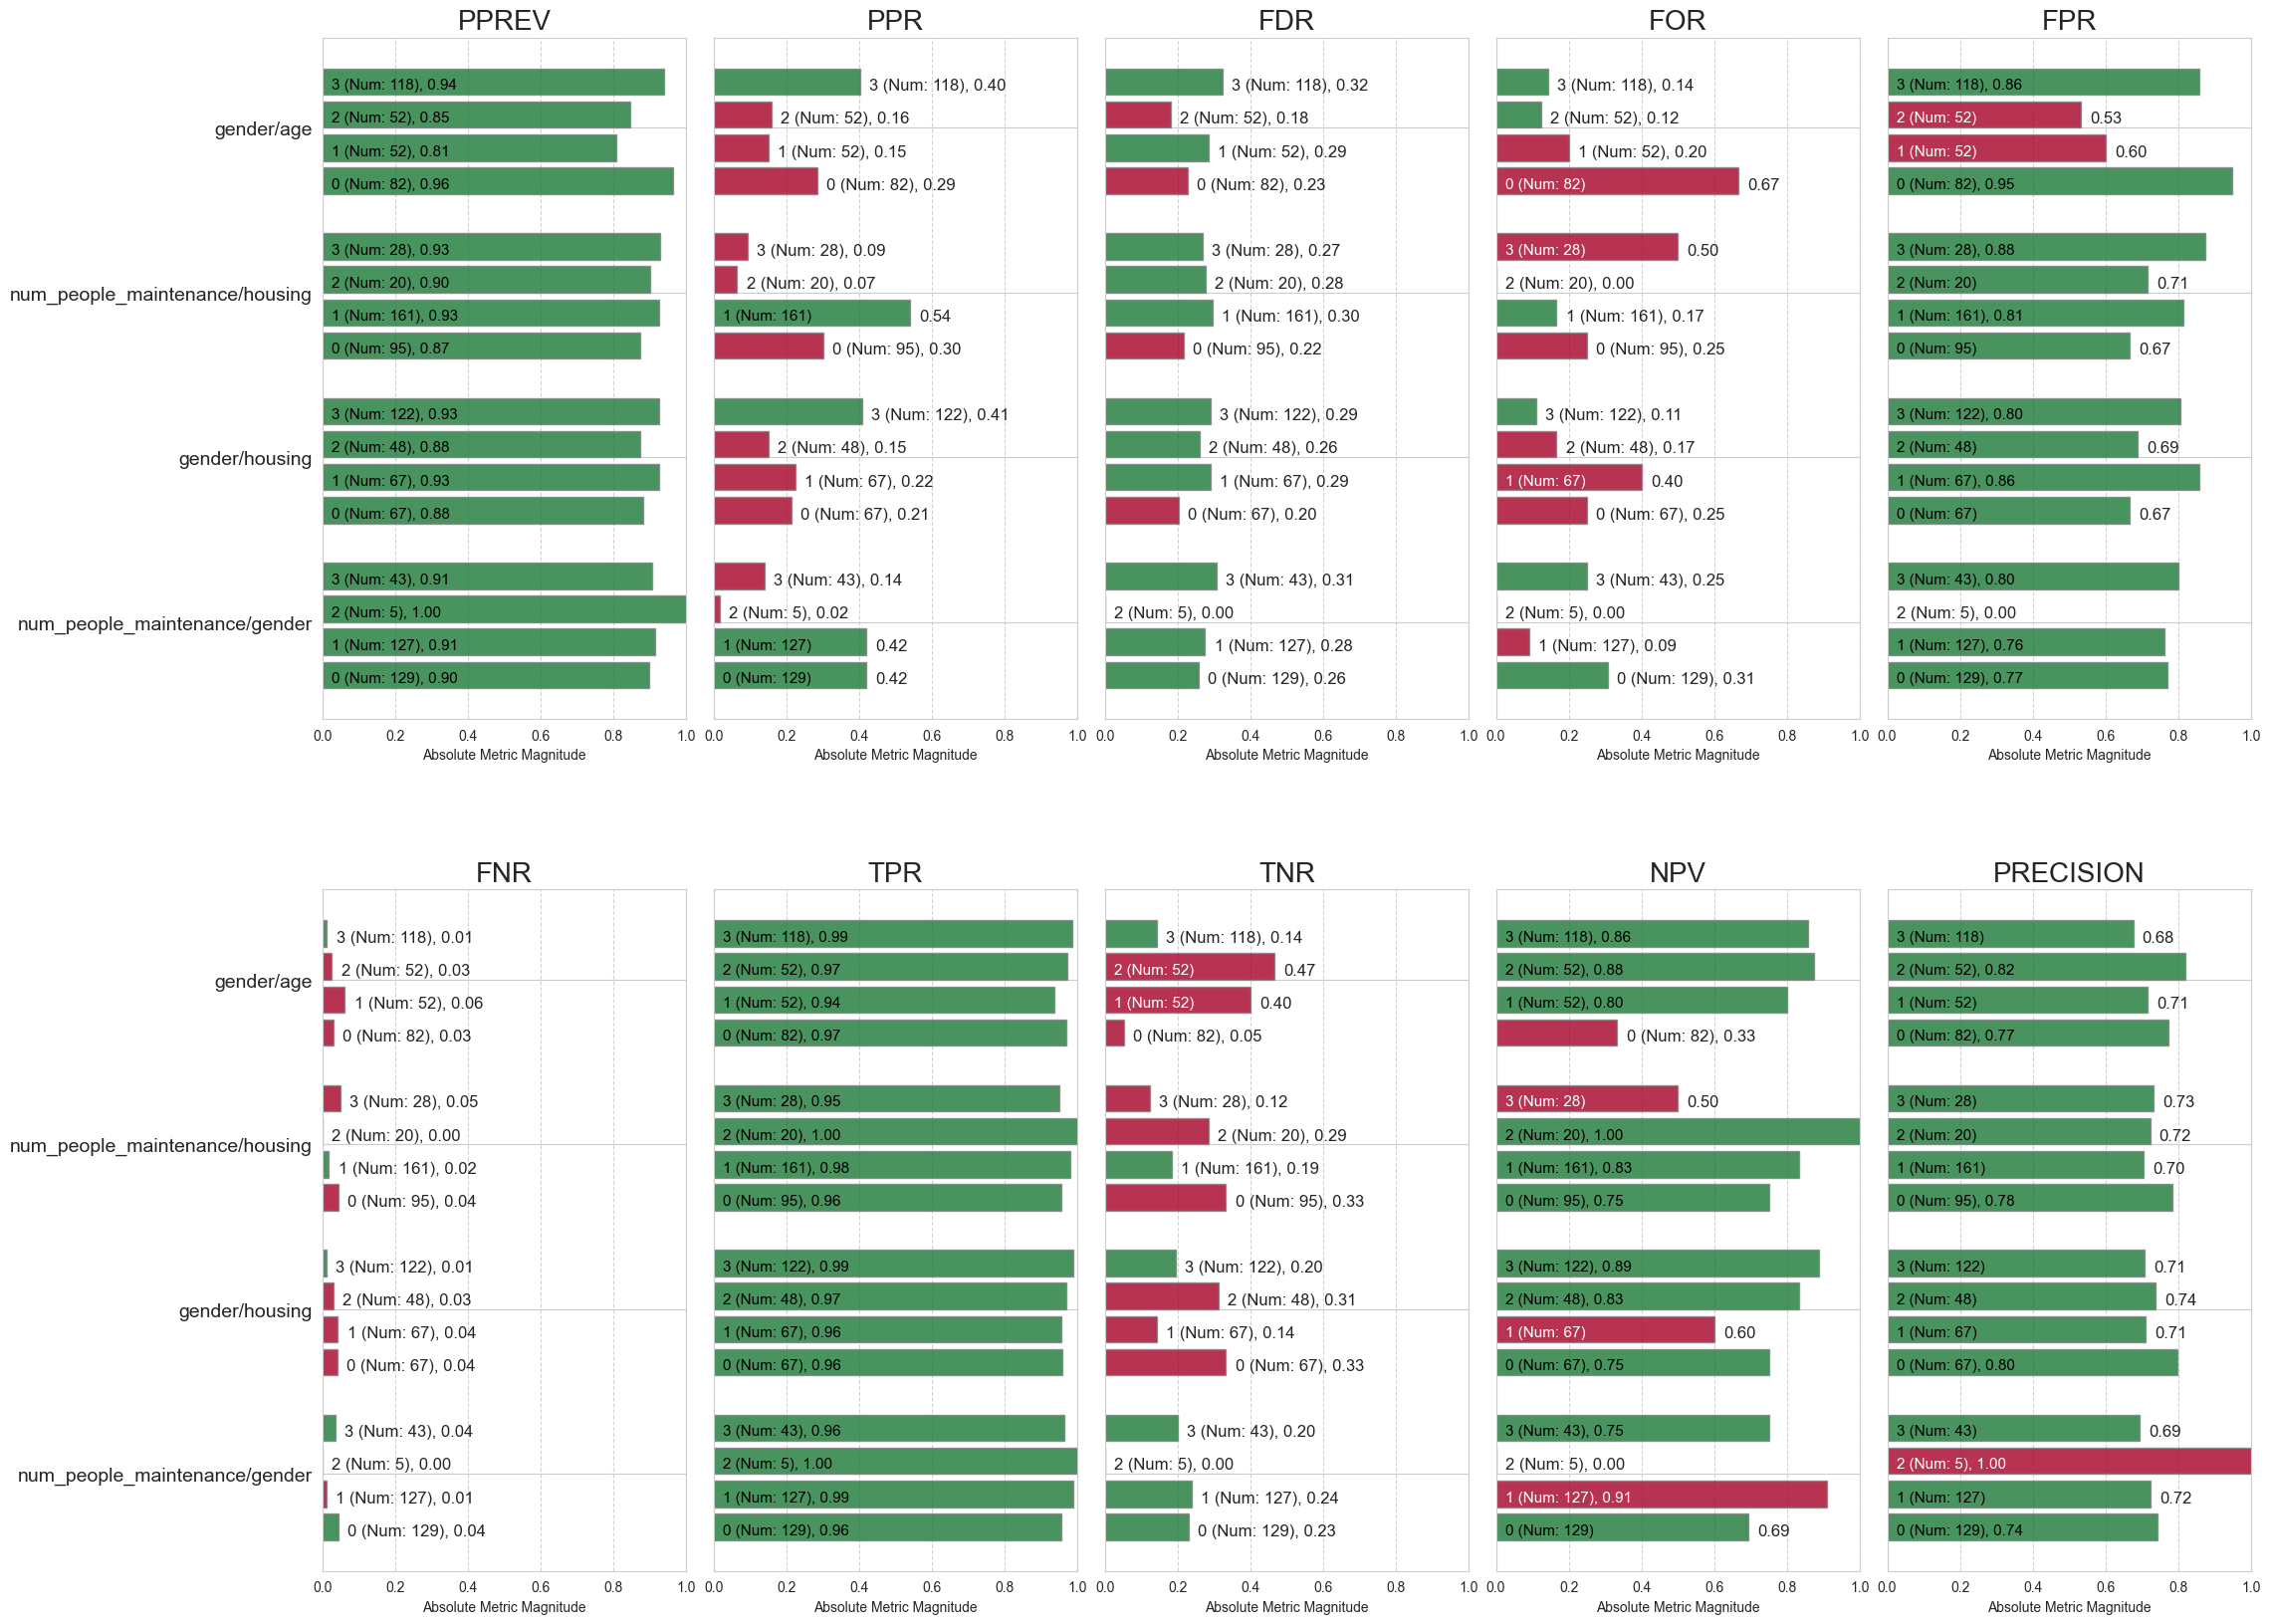

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
1,0,binary 0/1,gender/housing,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False
2,0,binary 0/1,num_people_maintenance/gender,False,True,False,True,False,False,True,True,False,False,False,False,False,False,False
3,0,binary 0/1,num_people_maintenance/housing,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [58]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_ps1 = pre_process_prev_sampling(data_to_transform, "num_people_maintenance/gender",target, strategy="oversample")
data_transformed_ps1["num_people_maintenance/gender"] = data_transformed_ps1["num_people_maintenance/gender"].astype(int)
data_transformed_ps2 = pre_process_prev_sampling(data_transformed_ps1, "gender/housing",target,strategy="oversample")
data_transformed_ps2["gender/housing"] = data_transformed_ps2["gender/housing"].astype(int)
data_transformed_ps3= pre_process_prev_sampling(data_transformed_ps2, "num_people_maintenance/housing",target,strategy="oversample")
data_transformed_ps3["num_people_maintenance/housing"] = data_transformed_ps3["num_people_maintenance/housing"].astype(int)
data_transformed_ps4= pre_process_prev_sampling(data_transformed_ps3, "gender/age",target,strategy="oversample")
data_transformed_ps4["gender/age"] = data_transformed_ps4["gender/age"].astype(int)
#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps4,protected_attributes_int)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["RandomForest"],target,protected_attributes_int, display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_ps, protected_attributes_int)

---------- Model name:  Catboost ----------

Accuracy score training:
0.8612
Accuracy score test:
0.7500
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Disparate Impact Ratio for num_people_maintenance/gender: 0.930
Normalized Disparate Impact Ratio for num_people_maintenance/gender: 0.930
Statistical Parity Difference for num_people_maintenance/gender: -0.059


Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 0.923
Normalized Disparate Impact Ratio for gender/housing: 0.923
Statistical Parity Difference for gender/housing: -0.066


Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_maint

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.74,0.95,0.24,0.33,0.25,0.76,0.05,0.67,0.75,0.27,0.89,0.70
1,num_people_maintenance/gender,1,0.72,0.94,0.10,0.62,0.25,0.90,0.06,0.38,0.75,0.58,0.93,0.74
2,num_people_maintenance/gender,2,0.67,1.00,0.00,NaN,0.33,1.00,0.00,NaN,0.67,0.02,1.00,0.67
3,num_people_maintenance/gender,3,0.75,1.00,0.00,NaN,0.25,1.00,0.00,NaN,0.75,0.13,1.00,0.75
4,gender/housing,0,0.70,1.00,0.33,0.00,0.35,0.67,0.00,1.00,0.65,0.09,0.85,0.55
5,gender/housing,1,0.75,0.94,0.11,0.67,0.22,0.89,0.06,0.33,0.78,0.20,0.92,0.78
6,gender/housing,2,0.58,0.95,0.07,0.50,0.42,0.93,0.05,0.50,0.58,0.17,0.94,0.58
7,gender/housing,3,0.78,0.95,0.09,0.67,0.20,0.91,0.05,0.33,0.80,0.54,0.94,0.79
8,num_people_maintenance/housing,0,0.64,0.96,0.20,0.20,0.38,0.80,0.04,0.80,0.62,0.23,0.89,0.57
9,num_people_maintenance/housing,1,0.76,0.94,0.11,0.67,0.21,0.89,0.06,0.33,0.79,0.63,0.93,0.79


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
Majority class for:  gender/age  is: 3
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,1.02,0.86,0.53,0.85,1.78,0.47,0.96,0.99,...,False,False,False,False,False,False,False,False,False,False
1,num_people_maintenance/gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,num_people_maintenance/gender,2,1.33,0.00,NaN,1.11,NaN,0.03,1.07,0.89,...,False,False,False,False,False,False,False,False,False,False
3,num_people_maintenance/gender,3,1.00,0.00,NaN,1.11,NaN,0.22,1.07,1.00,...,False,False,False,False,False,False,False,False,False,False
4,gender/housing,0,1.78,0.00,0.00,0.73,3.00,0.17,0.90,0.81,...,False,False,False,False,False,False,False,False,False,False
5,gender/housing,1,1.09,1.37,1.00,0.98,1.00,0.37,0.98,0.98,...,False,False,False,False,False,False,False,False,False,False
6,gender/housing,2,2.12,1.12,0.75,1.02,1.50,0.31,1.00,0.72,...,False,False,False,False,False,False,False,False,False,False
7,gender/housing,3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
8,num_people_maintenance/housing,0,1.86,0.61,0.30,0.90,2.40,0.36,0.96,0.78,...,False,False,False,False,False,False,False,False,False,False
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


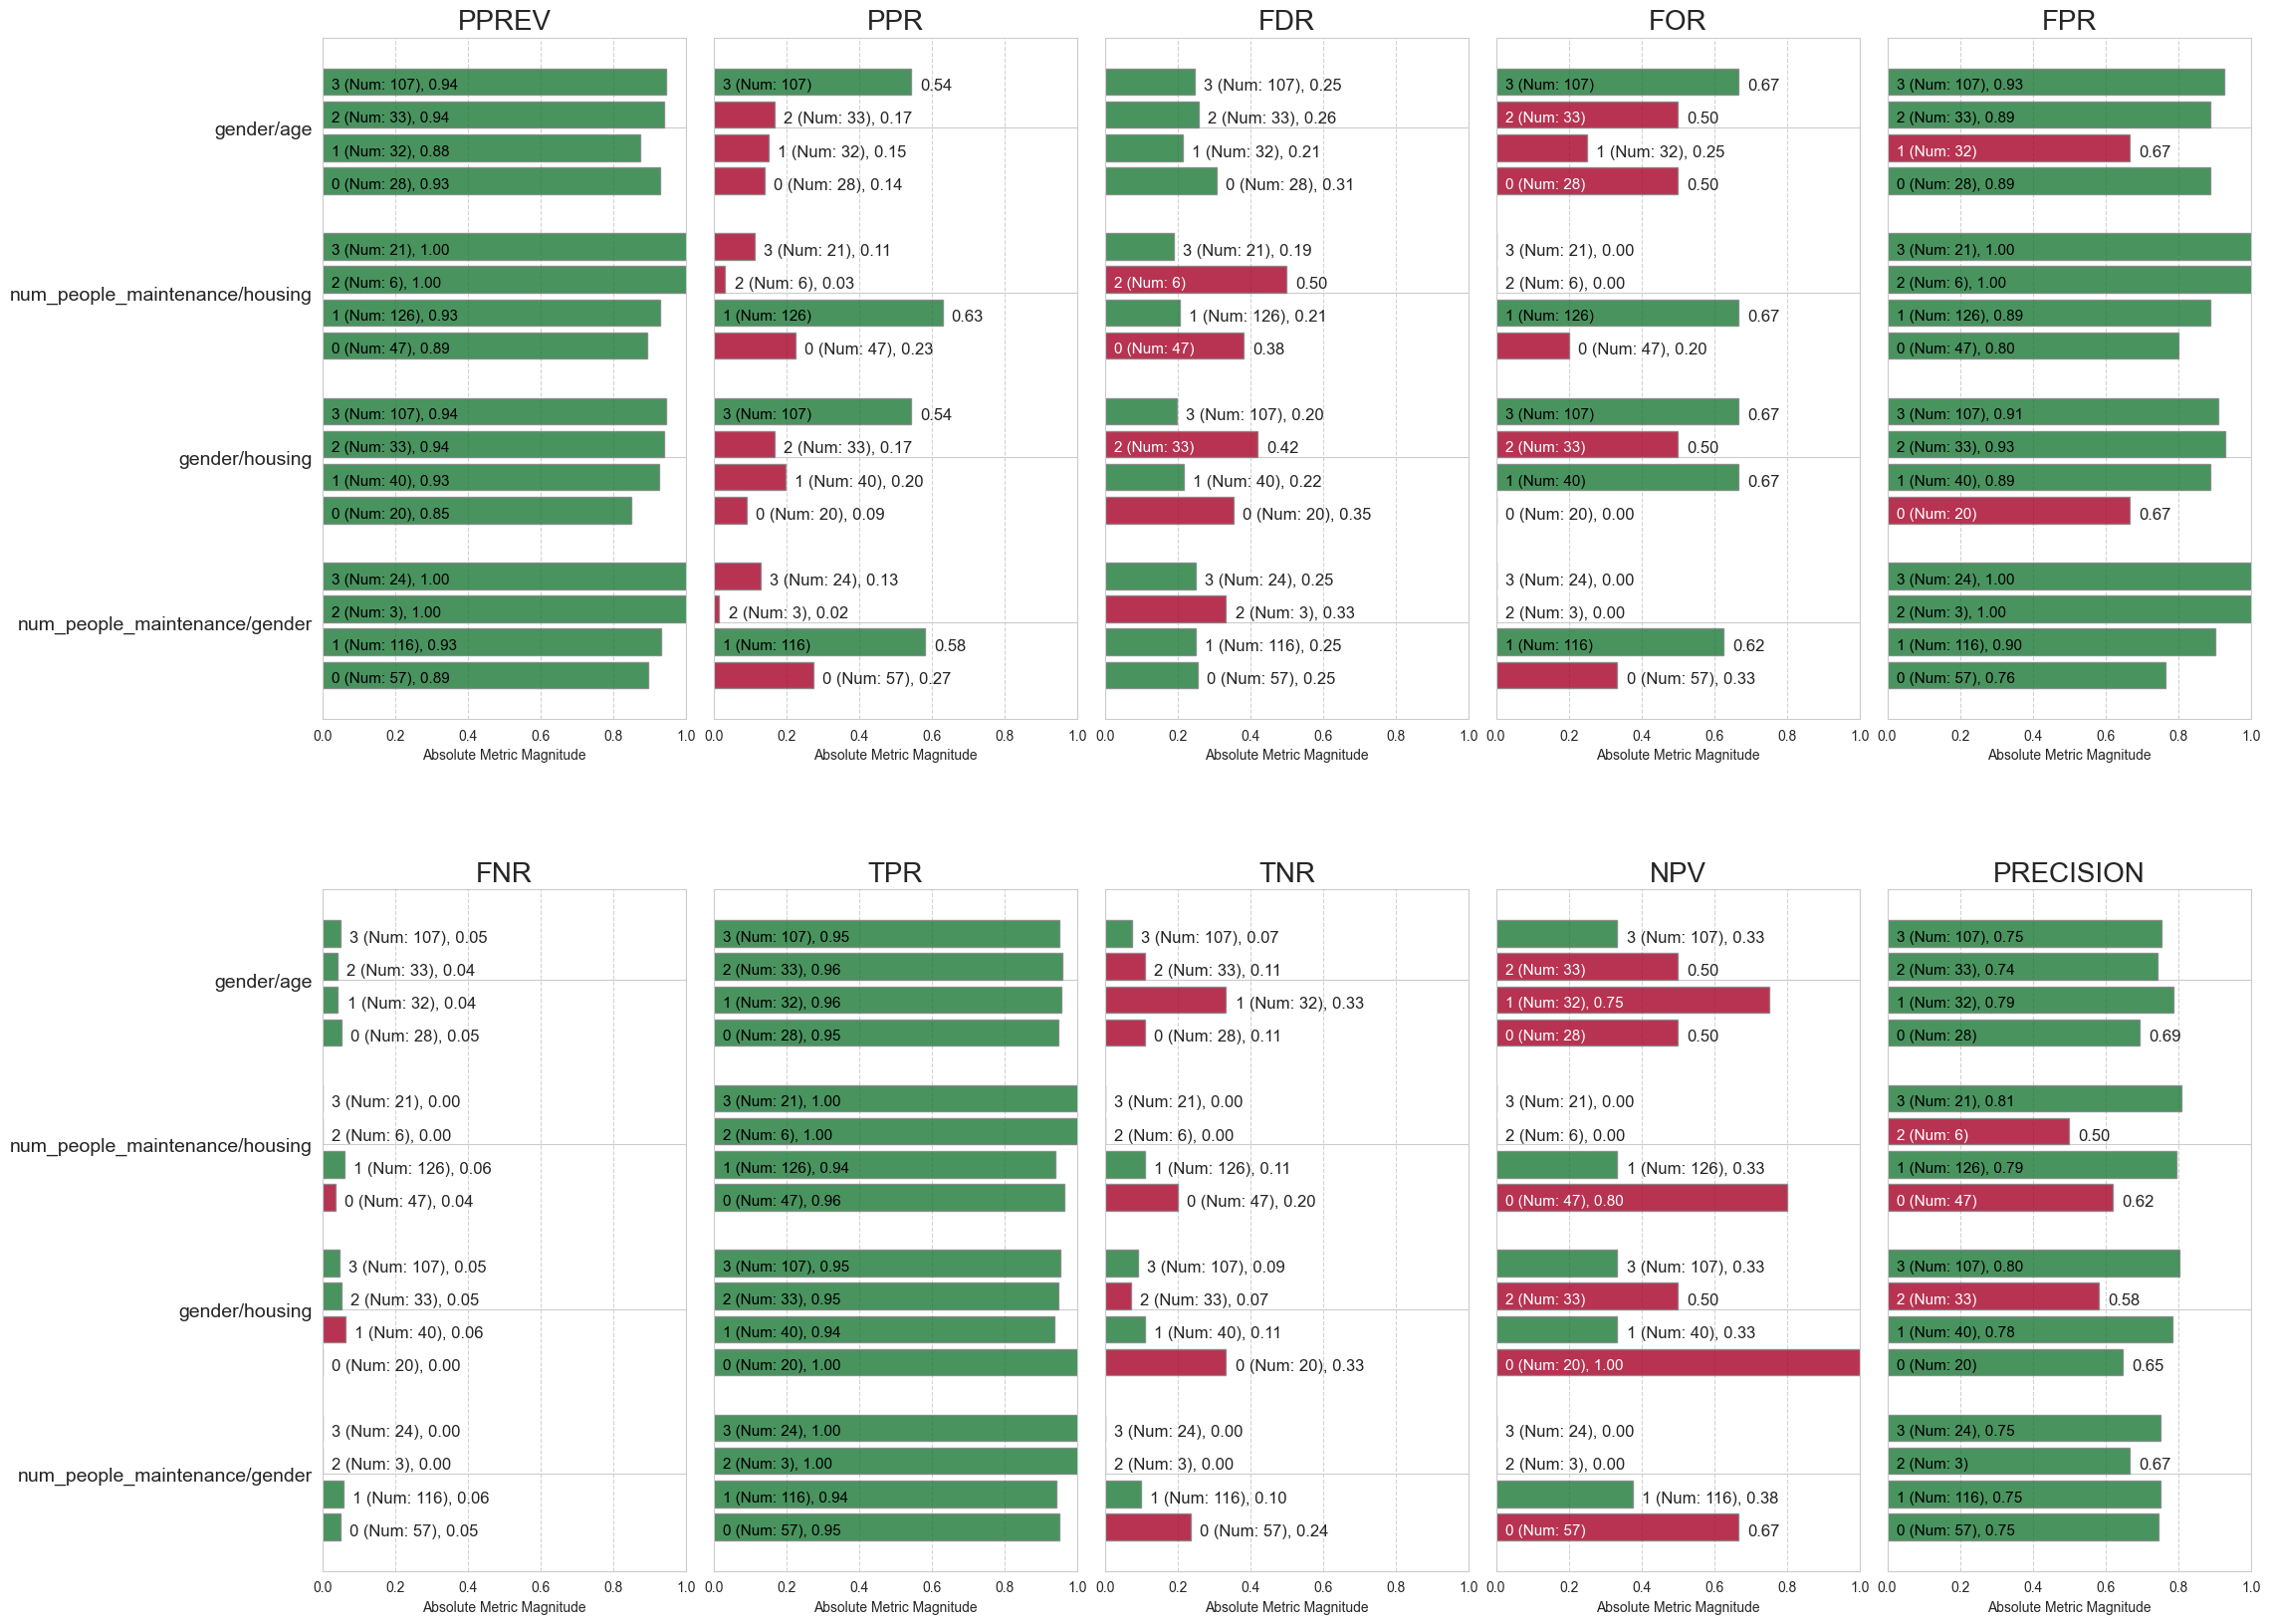

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,True,False,False,True,True,False,False,True,False,False,False,False,False
1,0,binary 0/1,gender/housing,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/gender,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False
3,0,binary 0/1,num_people_maintenance/housing,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [59]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''

#transform data
data_to_transform = df_num_int.copy()
columns_to_change = df_num_int.columns.difference(protected_attributes_int).tolist()
columns_to_change.remove(target)
data_transformed_dr1 = pre_process_data_repairer(data_to_transform, 'num_people_maintenance/gender',target,columns_to_change)
data_transformed_dr2 = pre_process_data_repairer(data_transformed_dr1, 'gender/housing',target,columns_to_change)
data_transformed_dr3 = pre_process_data_repairer(data_transformed_dr2, 'num_people_maintenance/housing',target,columns_to_change)
data_transformed_dr4 = pre_process_data_repairer(data_transformed_dr3, 'gender/age',target,columns_to_change)

data_transformed_dr4['num_people_maintenance/gender'] = data_transformed_dr3['num_people_maintenance/gender'].astype(int)
data_transformed_dr4['gender/housing'] = data_transformed_dr3['gender/housing'].astype(int)
data_transformed_dr4['num_people_maintenance/housing'] = data_transformed_dr3['num_people_maintenance/housing'].astype(int)
data_transformed_dr4['gender/age'] = data_transformed_dr3['gender/age'].astype(int)

#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_transformed_dr4,protected_attributes_int)

#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["RandomForest"],target,protected_attributes_int,display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_dr, protected_attributes_int)


In [60]:
'''
4. Label flipping
'''

#transform data
data_to_transform = df_num_int.copy()
data_transformed_lf1 = pre_process_label_flip(data_to_transform, 'gender/housing', target)
data_transformed_lf2 = pre_process_label_flip(data_transformed_lf1, 'num_people_maintenance/housing', target)
data_transformed_lf3 = pre_process_label_flip(data_transformed_lf2, 'num_people_maintenance/gender', target)
data_transformed_lf4 = pre_process_label_flip(data_transformed_lf3, 'gender/age', target)

data_transformed_lf4['gender/housing'] = data_transformed_lf4['gender/housing'].astype(int)
data_transformed_lf4['num_people_maintenance/housing'] = data_transformed_lf4['num_people_maintenance/housing'].astype(int)
data_transformed_lf4['num_people_maintenance/gender'] = data_transformed_lf4['num_people_maintenance/gender'].astype(int)
data_transformed_lf4['gender/age'] = data_transformed_lf4['gender/age'].astype(int)

#train
x_test_lf, y_test_lf, y_predicted_dict_lf, metrics_lf_dict = split_and_train(data_transformed_lf4,
                                                                             protected_attributes_int)

#calc metrics
df_test_transformed_lf = calc_fairness_report(x_test_lf, y_test_lf, y_predicted_dict_lf["RandomForest"], target,
                                              protected_attributes_int)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_lf, protected_attributes_int)

[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Flipped 37 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 37 instances.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Flipped 37 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 37 instances.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Flipped 37 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 37 instances.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Flipped 37 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 37 instances.


[INFO] 2024-10-15 10:11:33 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


---------- Model name:  Catboost ----------

Accuracy score training:
0.9750
Accuracy score test:
0.9200
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Disparate Impact Ratio for num_people_maintenance/gender: 1.021
Normalized Disparate Impact Ratio for num_people_maintenance/gender: 0.979
Statistical Parity Difference for num_people_maintenance/gender: 0.018


Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 0.915
Normalized Disparate Impact Ratio for gender/housing: 0.915
Statistical Parity Difference for gender/housing: -0.073


Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_mainte

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.93,0.98,0.62,0.17,0.06,0.38,0.02,0.83,0.94,0.27,0.89,0.86
1,num_people_maintenance/gender,1,0.91,0.99,0.29,0.20,0.09,0.71,0.01,0.80,0.91,0.59,0.96,0.88
2,num_people_maintenance/gender,2,1.00,1.00,NaN,NaN,0.00,NaN,0.00,NaN,1.00,0.02,1.00,1.00
3,num_people_maintenance/gender,3,0.96,1.00,0.67,0.00,0.05,0.33,0.00,1.00,0.95,0.12,0.92,0.88
4,gender/housing,0,0.95,1.00,0.80,0.00,0.06,0.20,0.00,1.00,0.94,0.09,0.80,0.75
5,gender/housing,1,0.92,0.97,0.33,0.50,0.05,0.67,0.03,0.50,0.95,0.20,0.95,0.92
6,gender/housing,2,0.85,1.00,0.38,0.00,0.17,0.62,0.00,1.00,0.83,0.16,0.91,0.76
7,gender/housing,3,0.93,0.99,0.33,0.25,0.06,0.67,0.01,0.75,0.94,0.55,0.96,0.92
8,num_people_maintenance/housing,0,0.87,1.00,0.45,0.00,0.14,0.55,0.00,1.00,0.86,0.22,0.89,0.77
9,num_people_maintenance/housing,1,0.93,0.98,0.36,0.33,0.06,0.64,0.02,0.67,0.94,0.64,0.95,0.91


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
Majority class for:  gender/age  is: 3
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,0.65,2.08,0.83,0.52,1.04,0.46,0.94,1.03,...,False,False,False,False,False,False,False,False,False,False
1,num_people_maintenance/gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,num_people_maintenance/gender,2,0.00,0.00,NaN,NaN,NaN,0.03,1.05,1.10,...,False,None,None,False,None,False,False,False,False,None
3,num_people_maintenance/gender,3,0.50,0.00,0.00,0.47,1.25,0.20,0.96,1.05,...,False,False,False,False,False,False,False,False,False,False
4,gender/housing,0,1.07,0.00,0.00,0.30,1.33,0.16,0.83,1.00,...,False,False,False,False,False,False,False,False,False,False
5,gender/housing,1,0.90,2.65,2.00,1.00,0.67,0.37,0.99,1.01,...,False,False,False,False,False,False,False,False,False,False
6,gender/housing,2,2.86,0.00,0.00,0.94,1.33,0.29,0.94,0.88,...,False,None,None,False,None,False,False,False,False,None
7,gender/housing,3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
8,num_people_maintenance/housing,0,2.45,0.00,0.00,0.86,1.50,0.35,0.94,0.91,...,False,False,False,False,False,False,False,False,False,False
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,False,False,False,False,True,False,True,True,False,False,False,False,False
1,0,binary 0/1,gender/housing,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/gender,False,True,False,False,False,False,True,False,True,True,False,False,False,False,False
3,0,binary 0/1,num_people_maintenance/housing,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [61]:
from aequitas.flow.methods.inprocessing import FairlearnClassifier

'''
In-processing: Fair learn classifier 
'''
def train_with_fairlearn(data, attribute, model, metrics_dict):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
    s_train = x_train[attribute]
    x_train = x_train.drop(columns= [attribute], axis=1)
    s_test = x_test[attribute]
    x_test = x_test.drop(columns= [attribute], axis=1)
    
    fairlearn_clf = FairlearnClassifier(estimator=model, constraint="fairlearn.reductions.FalsePositiveRateParity",reduction='fairlearn.reductions.ExponentiatedGradient')
    
    fairlearn_clf.fit(x_train, y_train, s_train) 
    y_train_pred = fairlearn_clf.predict_proba(x_train,s_train).astype(int)
    y_test_pred = fairlearn_clf.predict_proba(x_test,s_test).astype(int)
    x_test.insert(len(x_test.columns)-1,attribute,s_test,True) # insert back the attribute
    print("Model:\n", model)
    print(f"Accuracy score training:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Accuracy score test:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Classification report for model: {model} : \n {classification_report(y_test, y_test_pred)}")
    metric  = calc_metrics(x_test=x_test,y_test=y_test,y_predicted=y_test_pred,attributes=[attribute], target=target)
    metrics_dict[model] =metric
    return x_test, y_test, y_test_pred, metrics_dict


data_to_transform = df_num_int.copy()
models = ["sklearn.ensemble.RandomForestClassifier"]
metrics_dict = {}
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, "gender/age", models[0], metrics_dict)


[INFO] 2024-10-15 10:12:05 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


[INFO] 2024-10-15 10:12:05 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.FalsePositiveRateParity'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.FalsePositiveRateParity'>' with parameters: {}.


[INFO] 2024-10-15 10:12:05 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.ensemble.RandomForestClassifier
Accuracy score training:
1.0000
Accuracy score test:
0.7400
Classification report for model: sklearn.ensemble.RandomForestClassifier : 
               precision    recall  f1-score   support

           0       0.53      0.33      0.41        54
           1       0.78      0.89      0.83       146

    accuracy                           0.74       200
   macro avg       0.66      0.61      0.62       200
weighted avg       0.71      0.74      0.72       200

Privileged groups:  [{'gender/age': 3}]
Unprivileged groups:  [{'gender/age': 0}, {'gender/age': 1}, {'gender/age': 2}]
Disparate Impact Ratio for gender/age: 0.839
Normalized Disparate Impact Ratio for gender/age: 0.839
Statistical Parity Difference for gender/age: -0.145




In [62]:
df_test_transformed_fl =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int)
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_fl, protected_attributes_int)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.74,0.82,0.53,0.44,0.20,0.47,0.18,0.56,0.80,0.25,0.72,0.70
1,num_people_maintenance/gender,1,0.73,0.90,0.27,0.53,0.22,0.73,0.10,0.47,0.78,0.60,0.85,0.74
2,num_people_maintenance/gender,2,0.67,1.00,0.00,NaN,0.33,1.00,0.00,NaN,0.67,0.02,1.00,0.67
3,num_people_maintenance/gender,3,0.79,1.00,0.17,0.00,0.22,0.83,0.00,1.00,0.78,0.14,0.96,0.75
4,gender/housing,0,0.70,0.82,0.56,0.29,0.31,0.44,0.18,0.71,0.69,0.08,0.65,0.55
5,gender/housing,1,0.75,0.84,0.44,0.56,0.16,0.56,0.16,0.44,0.84,0.19,0.78,0.78
6,gender/housing,2,0.61,0.89,0.21,0.40,0.39,0.79,0.11,0.60,0.61,0.17,0.85,0.58
7,gender/housing,3,0.79,0.92,0.27,0.54,0.17,0.73,0.08,0.46,0.83,0.57,0.88,0.79
8,num_people_maintenance/housing,0,0.66,0.85,0.40,0.33,0.34,0.60,0.15,0.67,0.66,0.21,0.74,0.57
9,num_people_maintenance/housing,1,0.76,0.88,0.33,0.57,0.17,0.67,0.12,0.43,0.83,0.63,0.83,0.79


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
Majority class for:  gender/age  is: 3
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,0.88,1.67,0.83,0.64,1.20,0.41,0.84,1.03,...,False,False,False,False,False,False,False,False,False,False
1,num_people_maintenance/gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,True,True,False,False,False
2,num_people_maintenance/gender,2,1.50,0.00,NaN,1.36,NaN,0.03,1.17,0.86,...,False,False,False,False,False,False,False,False,False,False
3,num_people_maintenance/gender,3,0.98,0.00,0.00,1.14,2.12,0.23,1.12,1.01,...,False,False,False,False,False,False,False,False,False,False
4,gender/housing,0,1.81,2.21,0.53,0.61,1.55,0.14,0.74,0.83,...,False,False,False,False,False,False,False,False,False,False
5,gender/housing,1,0.95,1.96,1.03,0.76,0.96,0.33,0.88,1.01,...,False,False,False,False,False,True,True,False,False,False
6,gender/housing,2,2.31,1.28,0.74,1.08,1.30,0.30,0.97,0.73,...,False,False,False,False,False,False,False,False,False,False
7,gender/housing,3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
8,num_people_maintenance/housing,0,2.00,1.22,0.58,0.90,1.56,0.33,0.89,0.79,...,False,False,False,False,False,False,False,False,False,False
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,True,True,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
1,0,binary 0/1,gender/housing,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/gender,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
3,0,binary 0/1,num_people_maintenance/housing,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [64]:
df_test_fairlearn = post_process_group_threshold_fairlearn(df_num_int, protected_attributes_int, target)

---------- Model name:  RandomForest ----------



ValueError: Degenerate labels for sensitive feature value 2,1,3,0

---------- Model name:  RandomForest ----------

[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-10-15 10:17:46 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Privileged groups:  [{'gender/age': 3}]
Unprivileged groups:  [{'gender/age': 0}, {'gender/age': 1}, {'gender/age': 2}]
Disparate Impact Ratio for gender/age: 1.008
Normalized Disparate Impact Ratio for gender/age: 0.992
Statistical Parity Difference for gender/age: 0.008


Accuracy score test corrected:
0.7350


,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,gender/age,0,0.71,1.00,0.11,0.0,0.30,0.89,0.00,1.0,0.70,0.14,0.96,0.68
1,gender/age,1,0.72,1.00,0.00,NaN,0.28,1.00,0.00,NaN,0.72,0.16,1.00,0.72
2,gender/age,2,0.73,1.00,0.00,NaN,0.27,1.00,0.00,NaN,0.73,0.17,1.00,0.73
3,gender/age,3,0.73,0.98,0.00,1.0,0.26,1.00,0.02,0.0,0.74,0.53,0.98,0.75


Majority class for:  gender/age  is: 3
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,gender/age,0,1.15,0.0,0.0,0.89,10.0,0.26,0.98,0.95,...,False,None,None,False,None,False,False,False,False,None
1,gender/age,1,1.09,0.0,NaN,1.00,NaN,0.30,1.02,0.97,...,False,None,None,False,None,False,False,False,False,None
2,gender/age,2,1.06,0.0,NaN,1.00,NaN,0.31,1.02,0.98,...,False,None,None,False,None,False,False,False,False,None
3,gender/age,3,1.00,1.0,1.0,1.00,NaN,1.00,1.00,1.00,...,False,None,None,False,None,False,False,False,False,None


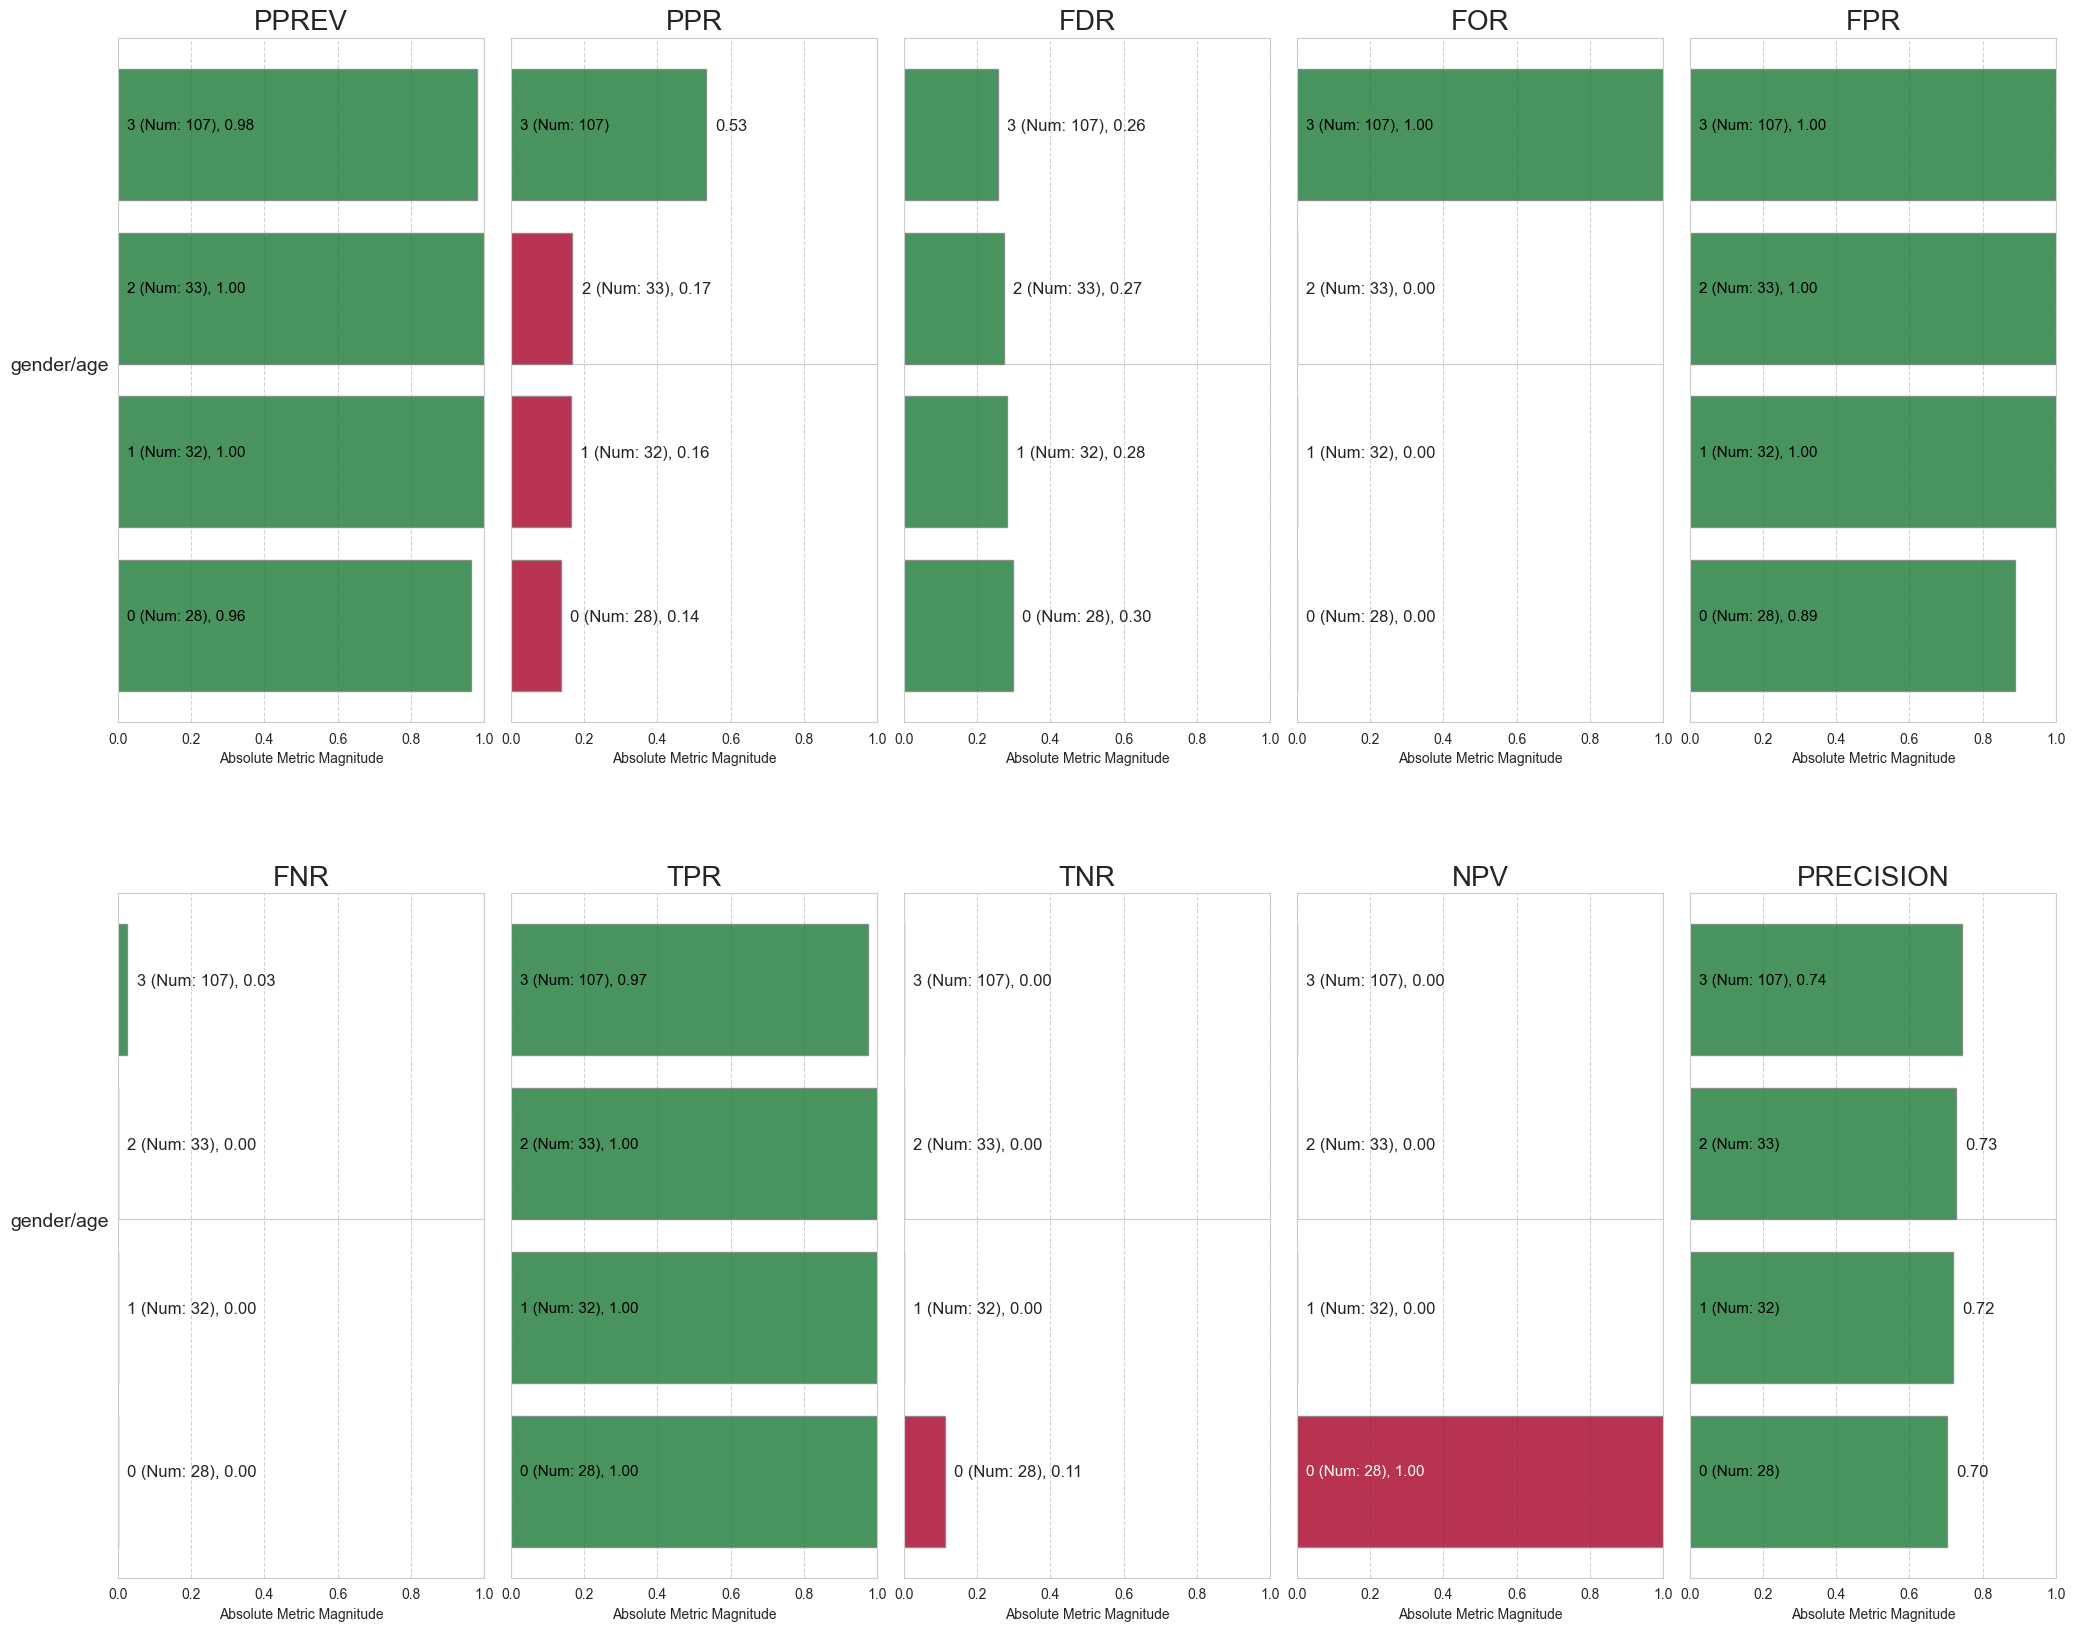

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,True,True,False,False,True,False,False,True,True,False,True,False,False


<Figure size 640x480 with 0 Axes>

In [65]:
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, 'gender/age', target)


In [ ]:
y_test_post_fl = post_process_group_threshold_fairlearn(df_num_int, 'gender/housing', target)
y_test_post_aeq = post_process_group_threshold_aequitas(df_num_int, 'gender/housing', target)

y_test_post_fl2 = post_process_group_threshold_fairlearn(df_num_int, 'num_people_maintenance/gender', target)
y_test_post_aeq2 = post_process_group_threshold_aequitas(df_num_int, 'num_people_maintenance/gender', target)

y_test_post_fl3 = post_process_group_threshold_fairlearn(df_num_int, 'num_people_maintenance/housing', target)
y_test_post_aeq3 = post_process_group_threshold_aequitas(df_num_int, 'num_people_maintenance/housing', target)

In [ ]:
plot_audit(df_test_int, ['gender/housing'])
plot_audit(y_test_post_fl, ['gender/housing'])
plot_audit(y_test_post_aeq, ['gender/housing'])

plot_audit(df_test_int, ['num_people_maintenance/gender'])
plot_audit(y_test_post_fl2, ['num_people_maintenance/gender'])
plot_audit(y_test_post_aeq2, ['num_people_maintenance/gender'])


plot_audit(df_test_int, ['num_people_maintenance/housing'])
plot_audit(y_test_post_fl3, ['num_people_maintenance/housing'])
plot_audit(y_test_post_aeq3, ['num_people_maintenance/housing'])

In [ ]:
index = 4 
plt.figure(figsize=(10, 6))
accuracy_scores = {}
accuracy_scores["Orignal dataset"] = {"Catboost": 0.79, "RandomForest":0.78, "DecisionTree":0.77, "LR":0.76}
accuracy_scores["Intersectional dataset"] = {"Catboost": 0.8, "RandomForest":0.78, "DecisionTree":0.76, "LR":0.76}
accuracy_scores["Massaging method"] = {"Catboost": 0.92, "RandomForest":0.87, "DecisionTree":0.86, "LR":0.83}
accuracy_scores["Prevelance Sampling"] = {"Catboost": 0.77, "RandomForest":0.75, "DecisionTree":0.73, "LR":0.73}
accuracy_scores["Data repairer"] = {"Catboost": 0.78, "RandomForest":0.76, "DecisionTree":0.75, "LR":0.76}

accuracy_df = pd.DataFrame(accuracy_scores).T
# Set the plot style
sns.set(style="whitegrid")
sns.set_palette("blend:#7AB,#EDA")
# Plot each method's accuracy scores
accuracy_df.plot(kind='bar', figsize=(10, 6))

# Add title and labels
plt.title("Accuracy Scores by Dataset and Model", fontsize=16)
plt.xlabel("Method", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['gender/housing']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['gender/housing']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['gender/housing']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['gender/housing']
plot_metrics(metrics_rf,'gender/housing')

metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['num_people_maintenance/gender']
plot_metrics(metrics_rf,'num_people_maintenance/gender')

metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['num_people_maintenance/housing']
plot_metrics(metrics_rf,'num_people_maintenance/housing')

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables)